# Import and Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, e
import random

In [3]:
adult = pd.read_csv("adult_with_pii.csv")
adult.head()

,Name,DOB,SSN,Zip,Workclass,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country,Target,Age,Capital Gain,Capital Loss
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K,56,2174,0
1,Brandise Tripony,6/7/1988,150-19-2766,61523,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K,35,0,0
2,Brenn McNeely,8/6/1991,725-59-9860,95668,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K,32,0,0
3,Dorry Poter,4/6/2009,659-57-4974,25503,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K,14,0,0
4,Dick Honnan,9/16/1951,220-93-3811,75387,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K,72,0,0


# Algorithm Functions

## Unary Encoding(UE)

In [5]:
def unary_epsilon(p, q):
    return np.log(p*(1-q)/((1-p)*q))

In [6]:
def symetric_p_q(epsilon):
    p = (e**(epsilon/2)) / (e**(epsilon/2) + 1)
    q = 1 / (e**(epsilon/2) + 1)

    return p, q

In [7]:
#calls perturb_bit to each element on the vector orginated from the 
def perturb(encoded_response, p, q):
    return [perturb_bit(b, p, q) for b in encoded_response]

#this is the function that perturbs the bits of the vector
def perturb_bit(bit, p, q):
    #generates the chance of the bit
    sample = np.random.random()
    
    if bit == 1:
        if sample <= p:
            #truth
            return 1
        else:
            #lie
            return 0
    elif bit == 0:
        if sample <= q:
            #lie
            return 1
        else:
            #truth
            return 0

In [8]:
#Aggregation that takes into consideration the number of fake responses on each category
def aggregate(responses, p, q):
    
    sums = np.sum(responses, axis = 0)
    n = len(responses)

    return [(v-n*q)/(p-q) for v in sums]

In [9]:
#encodes the response into a vector with binary entrances
def encode(response, domain):
    return [1 if d == response else 0 for d in domain]

In [10]:
#encodes the response into a vector with binary entrances, custom bin for a numeric variable
def encode_custom_bins(response, domain):
    
    encoded_vector = [0] * len(domain)
    
    for i, d in enumerate(domain):
        if i < len(domain) - 1:
            if response >= d and response < domain[i + 1]:
                encoded_vector[i] = 1
                break
        else:
            if response >= d:
                encoded_vector[i] = 1
                break
                
    return encoded_vector

## Optimized Unary Encoding(OUE)

In [11]:
def optimized_p_q(epsilon):
    p = 0.5
    q = 1/(e**epsilon + 1)

    return p, q

In [12]:
#test thingy
epsilon = 3

print(optimized_p_q(epsilon))
p, q = optimized_p_q(epsilon)
print(p)
print(q)
print("\n", unary_epsilon(p, q))

(0.5, 0.04742587317756679)
0.5
0.04742587317756679

 3.0


## Direct Encoding(DE)

In [13]:
def DE_p_q(epsilon, d):
    p = (e**epsilon) / (e**epsilon + d - 1)

    q = (1 - p) / (d - 1)

    return p, q

In [14]:
#case de mehcanism decides the response to be fake, ramdomly picks all the values but the truthful response of the domain
def random_pick_DE(domain, response):
    domain_q = [i for i in domain if i != response]

    return random.choice(domain_q)

In [15]:
def randomized_response_DE(epsilon, domain, response):
    d = len(domain)
    p, q = DE_p_q(epsilon, d)

    #generates the chance of the response
    sample = np.random.random()

    if sample <= p:
        return response
        
    else:
        return random_pick_DE(domain, response)

### Debug

In [16]:
attribute = 'Occupation'
domain = adult[attribute].dropna().unique()

countsTruth = np.sum([encode(r, domain) for r in adult[attribute]], axis = 0)

responses = [randomized_response_DE(3, domain, r) for r in adult['Occupation']]
countsDE = pd.Series(responses).value_counts()


print(countsTruth)
print("dsd", countsDE)

[3770 4066 1370 4140 3295 3650 4100 1597  994 2002  928  649    1    9
  149]
dsd Prof-specialty       3275
Craft-repair         3250
Exec-managerial      3237
Adm-clerical         3094
Sales                2974
Other-service        2787
Machine-op-inspct    2099
Transport-moving     1857
Handlers-cleaners    1713
Farming-fishing      1481
Tech-support         1426
Protective-serv      1345
Baby                  982
Priv-house-serv       975
Armed-Forces          954
Name: count, dtype: int64


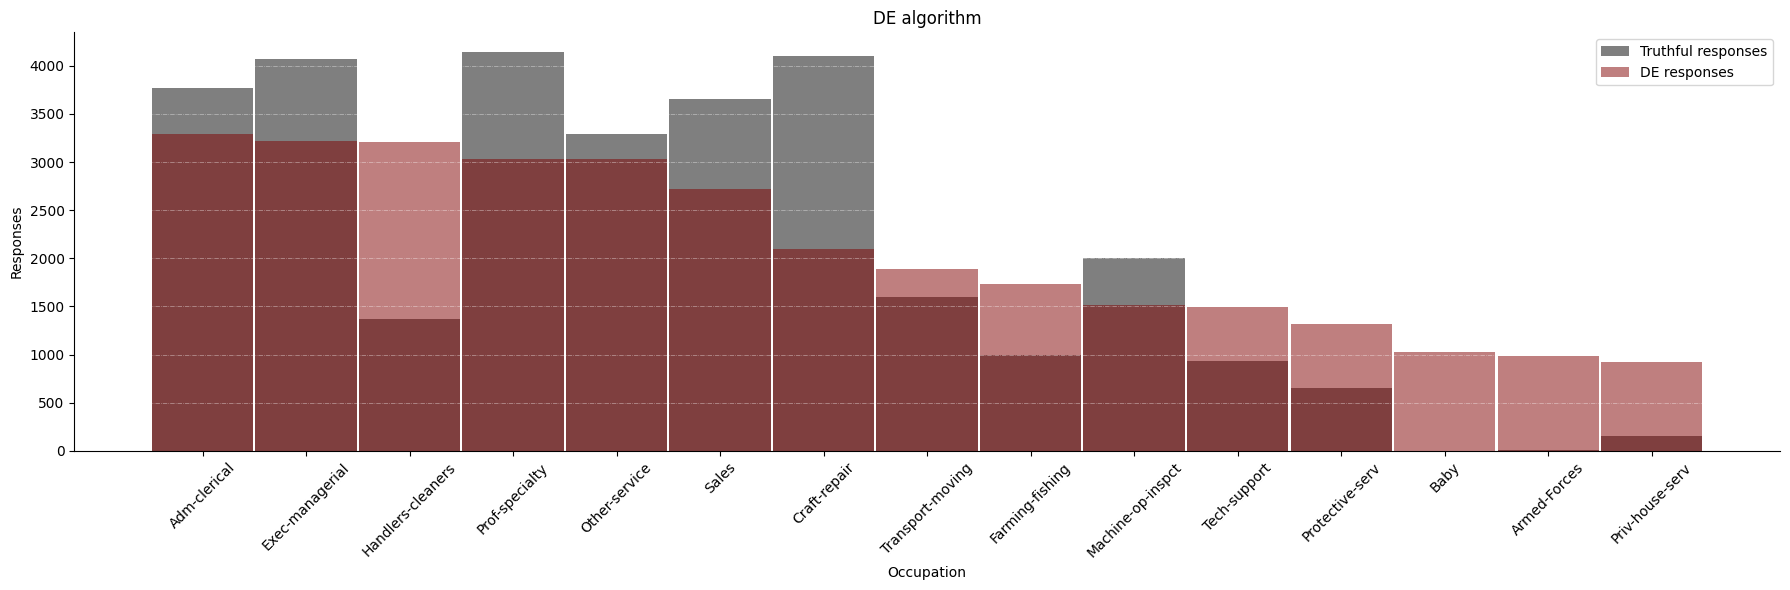

In [17]:
attribute = 'Occupation'
domain = adult[attribute].dropna().unique()

epsilon = 3
p, q = DE_p_q(epsilon, len(domain))

responses = [randomized_response_DE(3, domain, r) for r in adult['Occupation']]
countsDE = pd.Series(responses).value_counts()

countsTruth = np.sum([encode(r, domain) for r in adult[attribute]], axis = 0)

fig = plt.figure(figsize=(18, 6), facecolor='white')

plt.bar(domain, countsTruth, alpha=0.5, label='Truthful responses', align='center', color='black' , width = 0.98)
plt.bar(domain, countsDE, alpha=0.5, label='DE responses', align='center', color='maroon',  width = 0.98)

plt.xlabel(attribute)
plt.ylabel('Responses')
plt.title('DE algorithm')
plt.xticks(rotation=45)
plt.legend()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)
plt.minorticks_off()
#plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.5, color = 'black', which = 'both')
plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='white')


plt.tight_layout()
plt.savefig('DE.png', bbox_inches='tight', dpi=300)

plt.show()

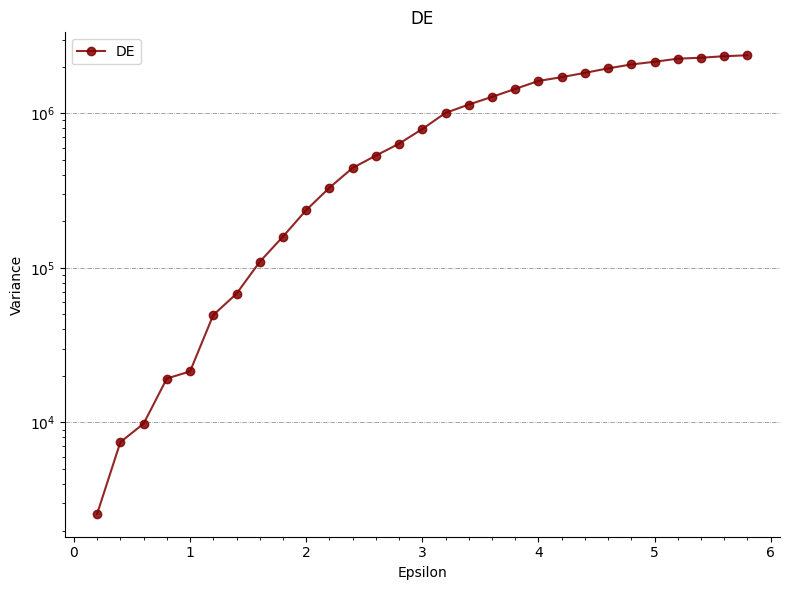

In [36]:
attribute = 'Occupation'
domain = adult[attribute].dropna().unique()

var_valuesDE= []
epsilon_values = []

for i in range(1, 30):
    epsilon = i/5

    responses = [randomized_response_DE(epsilon, domain, r) for r in adult['Occupation']]
    countsDE = pd.Series(responses).value_counts()
    
    var_valuesDE.append(sample_var(countsDE))
    epsilon_values.append(epsilon)

plt.figure(figsize=(8, 6))
plt.plot(epsilon_values, var_valuesDE, marker='o', color='maroon', alpha=0.85, label='DE')
plt.title('DE')
plt.xlabel('Epsilon')
plt.ylabel('Variance')
plt.yscale('log')
plt.legend()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)

plt.minorticks_on()
#plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.5, color = 'black', which = 'both')
plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='black')

plt.tight_layout()
plt.show()

# Metric functions and Analytics

In [19]:
def mean_calc(pdata):
    return sum(pdata) / len(pdata)

In [20]:
def analytical_var_optimized(n, epsilion):
    return n*((4*(e**epsilon)) / (e**epsilon-1)**2)

In [21]:
def analytical_var_symetric(n, epsilion):
    return n*( (e**(epsilon/2)) / (e**(epsilon/2)-1)**2)

In [22]:
def python_var(pdata):
    return np.var(pdata)

In [23]:
def population_var(pdata):
    mean = mean_calc(pdata)
    var = sum((x - mean) ** 2 for x in pdata) / len(pdata)
    return var

In [24]:
def sample_var(pdata):
    mean = mean_calc(pdata)
    var = sum((i - mean)**2 for i in pdata) / (len(pdata) - 1)
    return var

In [25]:
pdata = np.array([2.3, 4.5, 6.7, 8.9, 10.1])
print("Npy's variance", python_var(pdata))
print("Population's variance", sample_var(pdata))
print("Sample's variance", population_var(pdata))


Npy's variance 8.08
Population's variance 10.1
Sample's variance 8.08


In [26]:
def mean_pct_error(exact, approx):
    n = len(exact)
    ag_error = 0

    for i in range(n):
        ag_error += ((exact[i] - approx[i])/exact[i])*100

    mean_error = ag_error/n
    return mean_error

In [27]:
def rmse(exact, approx):
    n = len(exact)
    mse = 0

    for i in range(n):
        mse += (exact[i] - approx[i])**2

    rmse = sqrt(mse/n)
    return rmse

# Algorithm deploy

## Graphing and styling

### Histogrammer

In [28]:
def histogram_maker_3subplots(epsilon, attribute):
    domain = adult[attribute].dropna().unique()
    
    #-#----------------------------------------------------------------------------#
    pOUE, qOUE = optimized_p_q(epsilon)
    
    responsesOUE = [perturb(encode(r, domain), pOUE, qOUE) for r in adult[attribute]]
    countsOUE = aggregate(responsesOUE, pOUE, qOUE)
    
    responsesUE = [perturb(encode(r, domain), 0.75, 0.25) for r in adult[attribute]]
    countsUE = aggregate(responsesUE, 0.75, 0.25)
    
    
    pDE, qDE = DE_p_q(epsilon, len(domain))
    
    responsesDE = [randomized_response_DE(3, domain, r) for r in adult[attribute]]
    countsDE = pd.Series(responsesDE).value_counts()
    
    countsTruth = np.sum([encode(r, domain) for r in adult[attribute]], axis = 0)
    #-#----------------------------------------------------------------------------#
    
    
    fig = plt.figure(figsize=(25, 6), facecolor='white')
    
    ##################################################################################################################
    plt.subplot(1, 3, 1)
    plt.bar(domain, countsTruth, alpha=0.5, label='Truthful responses', align='center', color='lime' , width = 0.97)
    plt.bar(domain, countsOUE, alpha=0.5, label='OUE responses', align='center', color='blue',  width = 0.97)
    
    plt.xlabel(attribute)
    plt.ylabel('Responses')
    plt.title('OUE algorithm')
    plt.xticks(rotation=90)
    plt.legend()
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    #plt.gca().spines['bottom'].set_visible(False)
    #plt.gca().spines['left'].set_visible(False)
    plt.minorticks_off()
    #plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.5, color = 'black', which = 'both')
    plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='white')
    
    ###################################################################################################################
    
    plt.subplot(1, 3, 2)
    plt.bar(domain, countsTruth, alpha=0.5, label='Truthful responses', align='center', color='lime' , width = 0.97)
    plt.bar(domain, countsUE, alpha=0.5, label='Unary responses', align='center', color='blue',  width = 0.97)
    
    plt.xlabel(attribute)
    plt.ylabel('Responses')
    plt.title('UE algorithm')
    plt.xticks(rotation=90)
    plt.legend()
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    #plt.gca().spines['bottom'].set_visible(False)
    #plt.gca().spines['left'].set_visible(False)
    plt.minorticks_off()
    #plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.5, color = 'black', which = 'both')
    plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='white')
    
    ######################################################################################################################
    
    plt.subplot(1, 3, 3)
    
    plt.bar(domain, countsTruth, alpha=0.5, label='Truthful responses', align='center', color='lime' , width = 0.97)
    plt.bar(domain, countsDE, alpha=0.5, label='DE responses', align='center', color='blue',  width = 0.97)
    
    plt.xlabel(attribute)
    plt.ylabel('Responses')
    plt.title('DE algorithm')
    plt.xticks(rotation=90)
    plt.legend()
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    #plt.gca().spines['bottom'].set_visible(False)
    #plt.gca().spines['left'].set_visible(False)
    plt.minorticks_off()
    #plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.5, color = 'black', which = 'both')
    plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='white')
    
    ######################################################################################################################
    
    plt.tight_layout()
    plt.savefig('OUEvsUEvsDE.png', bbox_inches='tight', dpi=300)
    
    plt.show()

### Variancemer

In [29]:
def plot_var_3transplots(samples, attribute):
    domain = adult[attribute].dropna().unique()
    
    var_valuesOUE = []
    var_valuesUE = []
    var_valuesDE = []
    epsilon_values = []
    
    for i in range(1, samples):
        epsilon = i/5
    
        pOUE, qOUE = optimized_p_q(epsilon)
        pUE, qUE = symetric_p_q(epsilon)
        pDE, qDE = DE_p_q(epsilon, len(domain))
    
        ##----
        responsesOUE = [perturb(encode(r, domain), pOUE, qOUE) for r in adult[attribute]]
        countsOUE = aggregate(responsesOUE, pOUE, qOUE)
    
        responsesUE = [perturb(encode(r, domain), pUE, qUE) for r in adult[attribute]]
        countsUE = aggregate(responsesUE, pUE, qUE)
    
        responsesDE = [randomized_response_DE(epsilon, domain, r) for r in adult[attribute]]
        countsDE = pd.Series(responsesDE).value_counts()
        countsDE = countsDE.astype(np.float64).tolist()
        ##----
    
        var_valuesOUE.append(sample_var(countsOUE))
        var_valuesUE.append(sample_var(countsUE))
        var_valuesDE.append(sample_var(countsDE))
        epsilon_values.append(epsilon)
    
    plt.figure(figsize=(24, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(epsilon_values, var_valuesOUE, marker='o', color='lime', alpha=0.85, label='OUE')
    plt.plot(epsilon_values, var_valuesUE, marker='^', color='blue', alpha=0.65, label='UE')
    plt.plot(epsilon_values, var_valuesDE, marker='+', color='maroon', alpha=0.75, label='DE')
    
    plt.title('Variance\nOUE vs UE vs DE')
    plt.xlabel(f'Epsilon\n(d={len(domain)})')
    plt.ylabel('Variance')
    plt.yscale('log')
    #plt.ylim([1e4, 1e7])
    plt.legend()
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    #plt.gca().spines['bottom'].set_visible(False)
    #plt.gca().spines['left'].set_visible(False)
    
    plt.minorticks_on()
    #plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.5, color = 'black', which = 'both')
    plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='black')
    
    
    plt.tight_layout()
    plt.show()

### rmseemer

In [34]:
def plot_rmse_3transplots(samples, attribute):
    domain = adult[attribute].dropna().unique()
    
    rmse_valuesDE = []
    rmse_valuesUE = []
    rmse_valuesOUE = []
    epsilon_values = []
    
    for i in range(1, samples):
        epsilon = i/5
    
        pOUE, qOUE = optimized_p_q(epsilon)
        pUE, qUE = symetric_p_q(epsilon)
        pDE, qDE = DE_p_q(epsilon, len(domain))
    
        ##----
        responsesOUE = [perturb(encode(r, domain), pOUE, qOUE) for r in adult[attribute]]
        countsOUE = aggregate(responsesOUE, pOUE, qOUE)
    
        responsesUE = [perturb(encode(r, domain), pUE, qUE) for r in adult[attribute]]
        countsUE = aggregate(responsesUE, pUE, qUE)
    
        responsesDE = [randomized_response_DE(epsilon, domain, r) for r in adult[attribute]]
        countsDE = pd.Series(responsesDE).value_counts()
        countsDE = countsDE.astype(np.float64).tolist()

        countsTruth = np.sum([encode(r, domain) for r in adult[attribute]], axis = 0)
        ##----
    
        rmse_valuesOUE.append(rmse(countsTruth, countsOUE))
        rmse_valuesUE.append(rmse(countsTruth, countsUE))
        rmse_valuesDE.append(rmse(countsTruth, countsDE))
        epsilon_values.append(epsilon)
    
    plt.figure(figsize=(24, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(epsilon_values, rmse_valuesOUE, marker='o', color='lime', alpha=0.85, label='OUE')
    plt.plot(epsilon_values, rmse_valuesUE, marker='^', color='blue', alpha=0.65, label='UE')
    plt.plot(epsilon_values, rmse_valuesDE, marker='+', color='maroon', alpha=0.75, label='DE')
    
    plt.title('Root Mean Square deviation\nOUE vs UE vs DE')
    plt.xlabel(f'Epsilon\n(d={len(domain)})')
    plt.ylabel('rmse')
    plt.yscale('log')
    #plt.ylim([1e4, 1e7])
    plt.legend()
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    #plt.gca().spines['bottom'].set_visible(False)
    #plt.gca().spines['left'].set_visible(False)
    
    plt.minorticks_on()
    #plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.5, color = 'black', which = 'both')
    plt.grid(axis='y', linestyle='-.', linewidth=0.5, alpha=0.5, color='black')
    
    
    plt.tight_layout()
    plt.show()

## Race domain (d = 5)

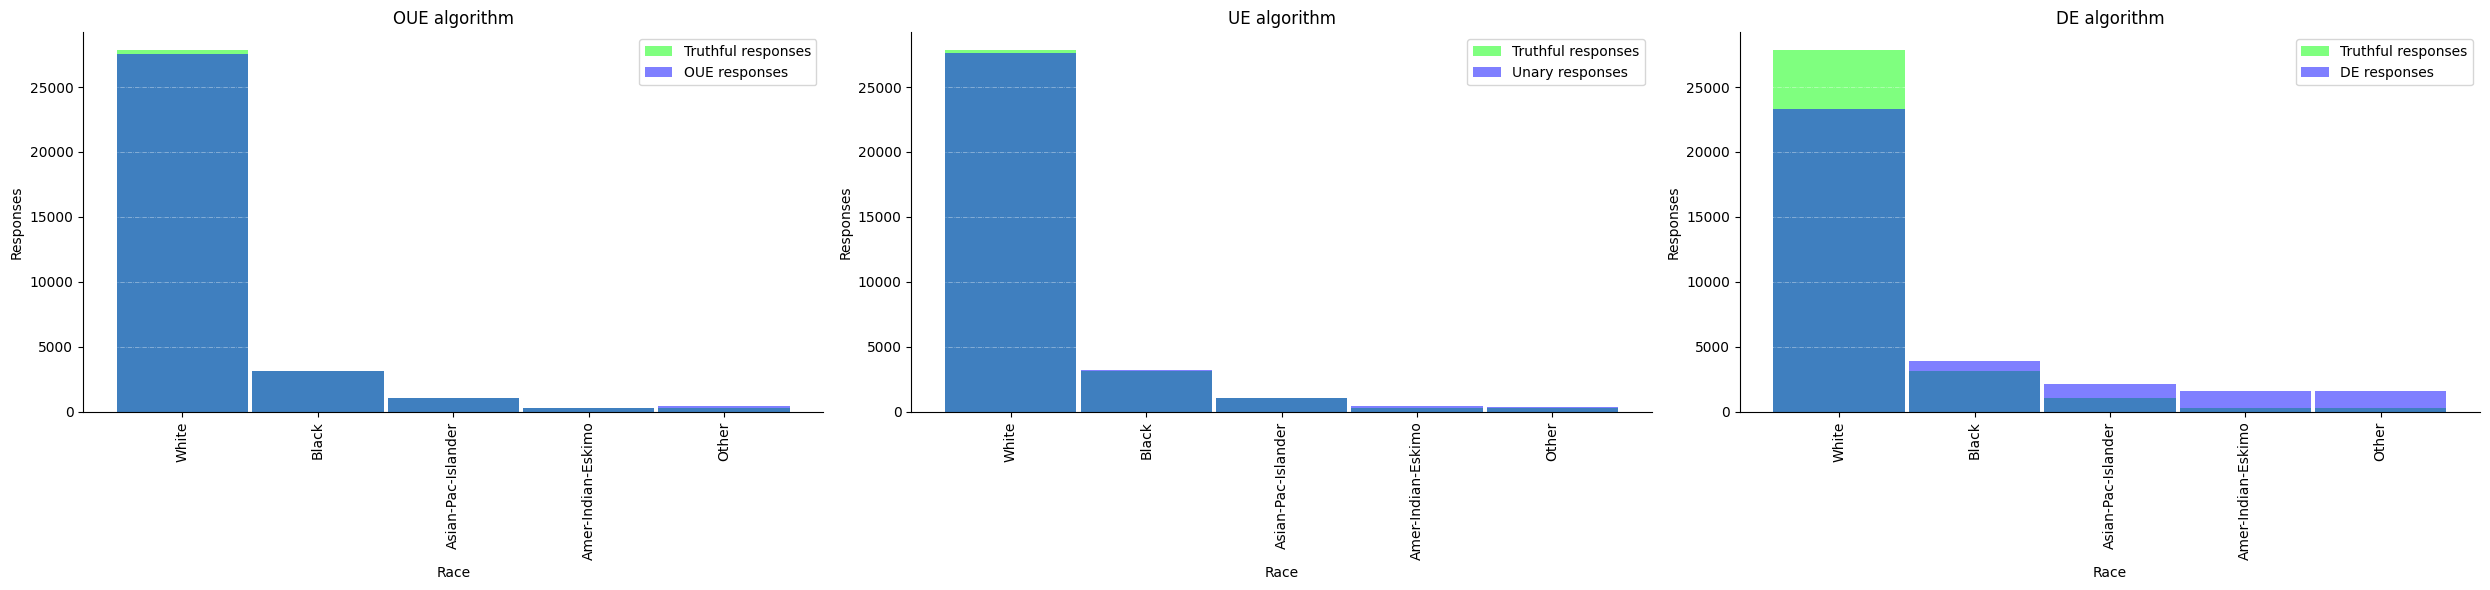

In [204]:
histogram_maker_3subplots(3, 'Race')

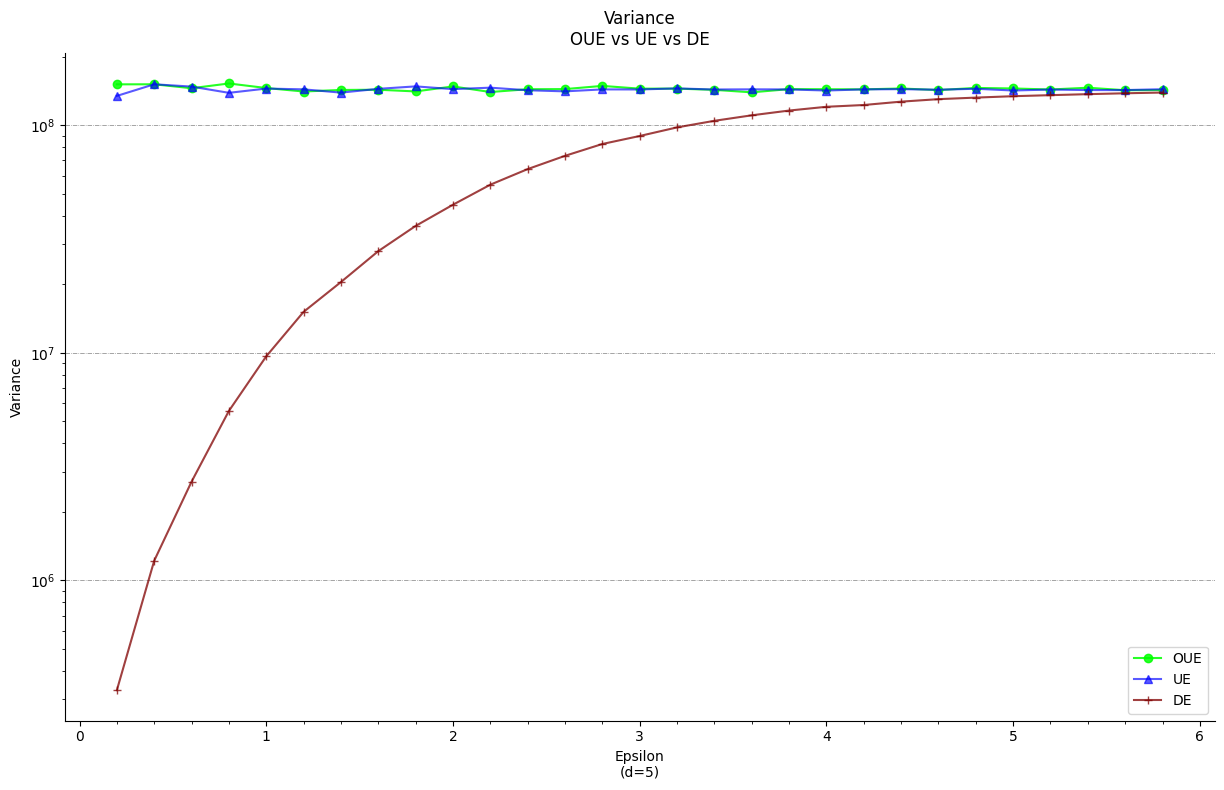

In [161]:
plot_var_3transplots(30, 'Race')

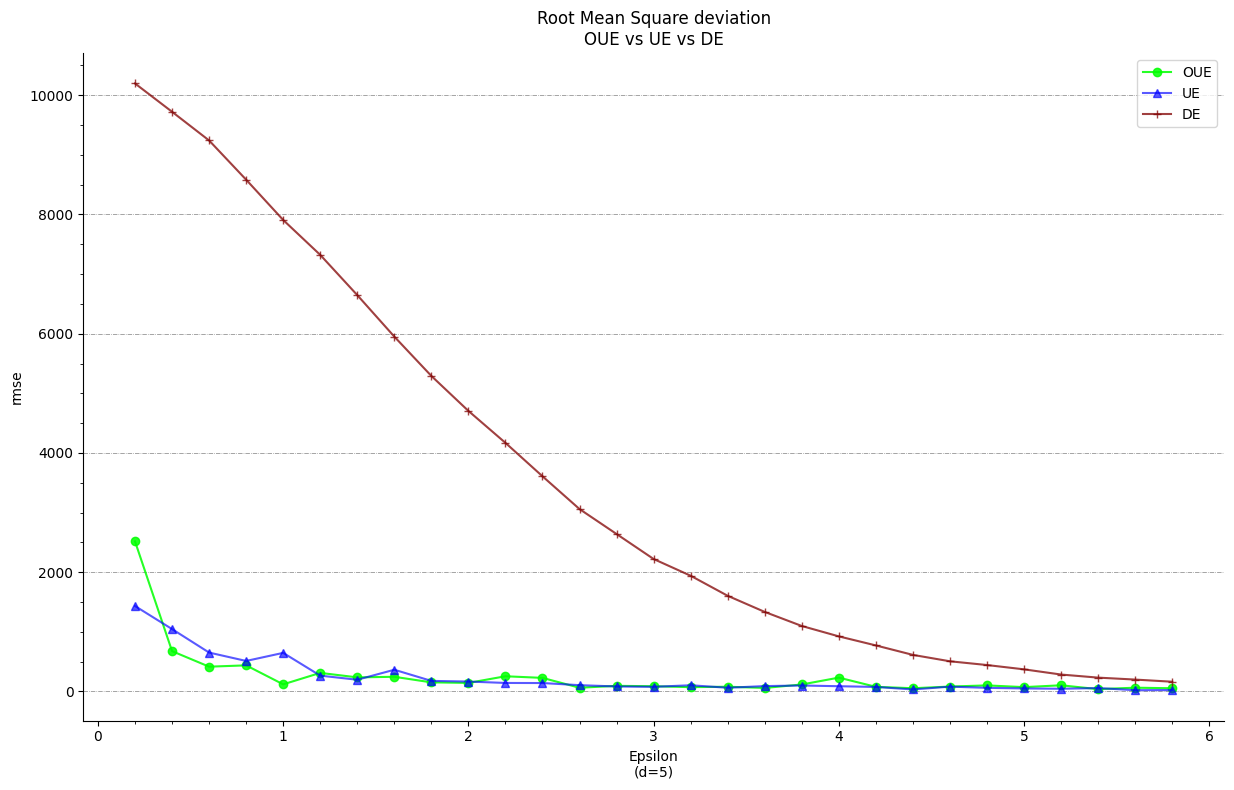

In [162]:
plot_rmse_3transplots(30, 'Race')

## Occupation domain (d = 16)

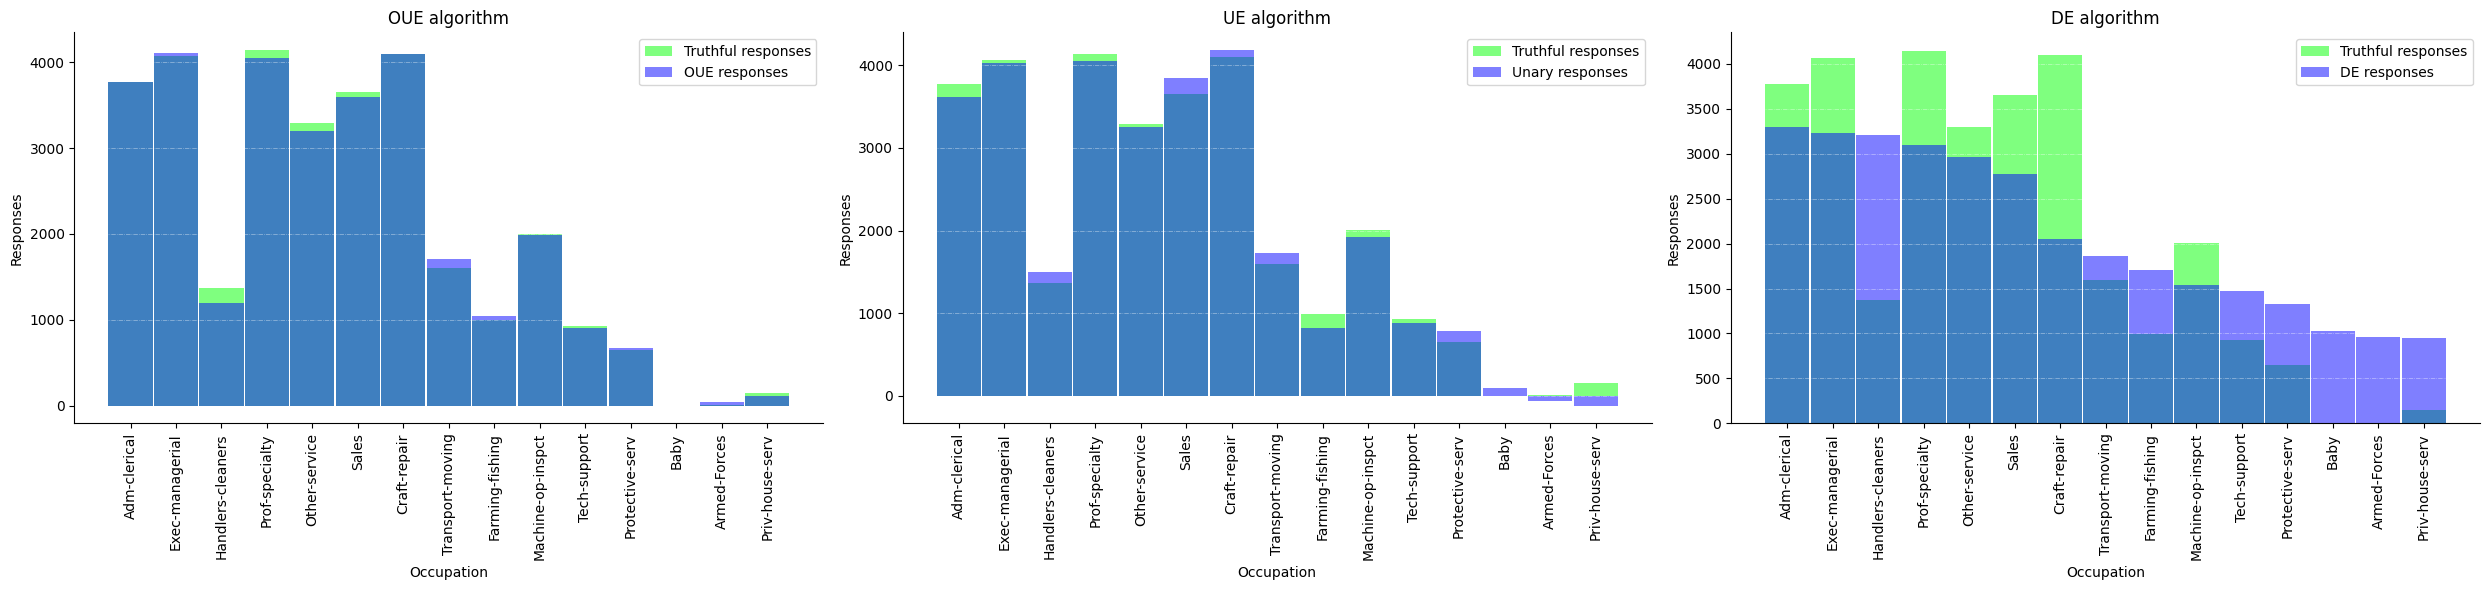

In [174]:
histogram_maker_3subplots(3, 'Occupation')

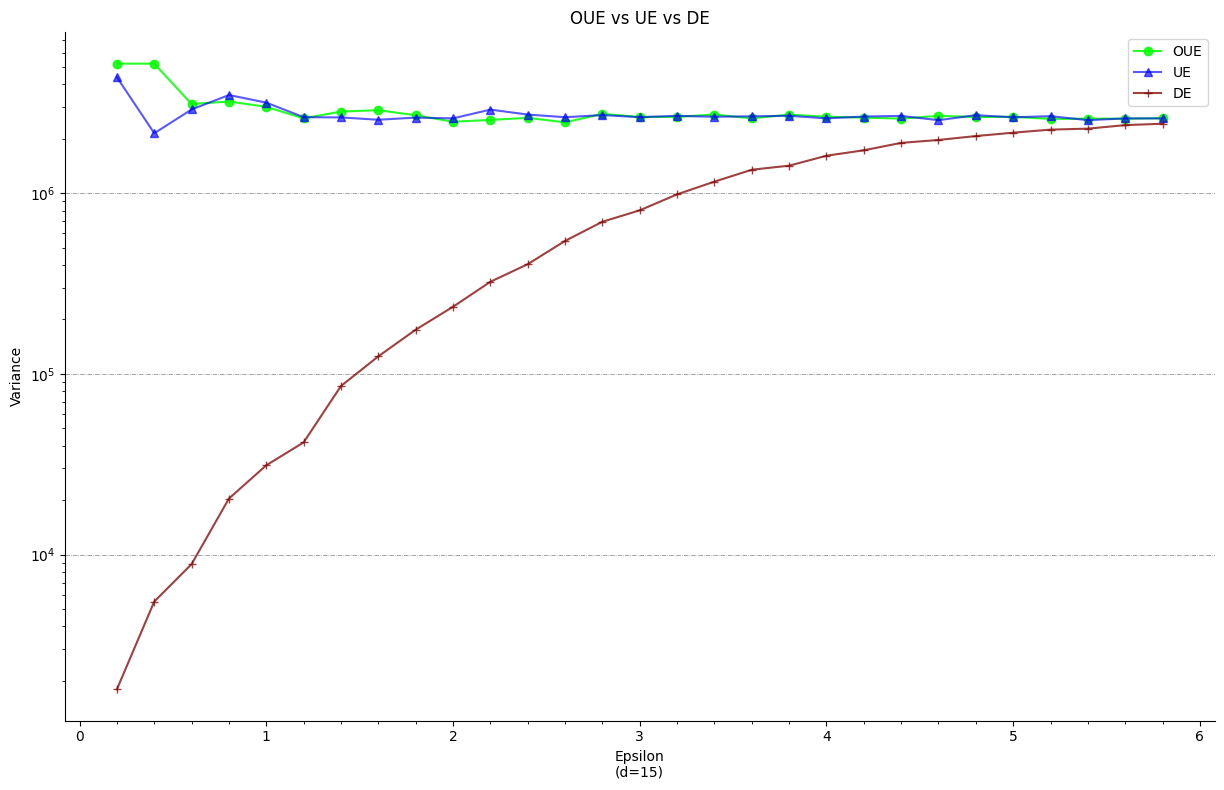

In [143]:
plot_var_3transplots(30, 'Occupation')

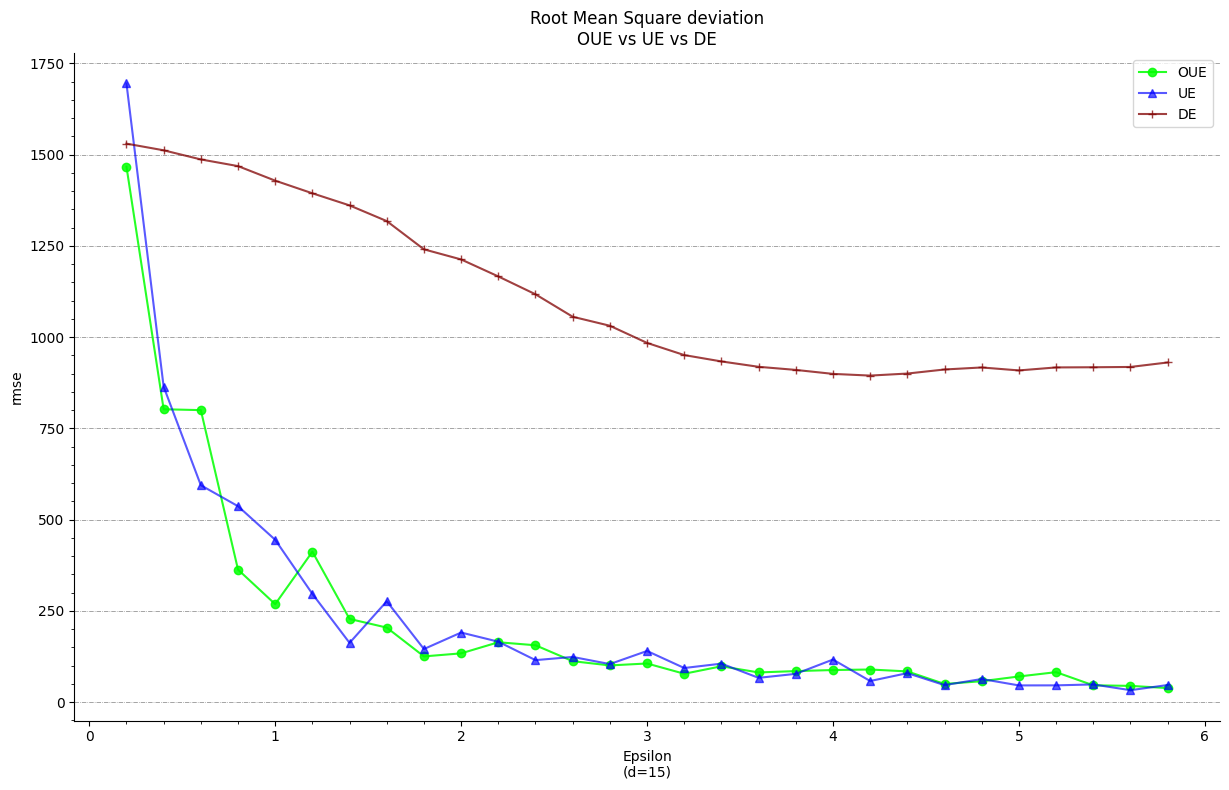

In [169]:
plot_rmse_3transplots(30, 'Occupation')

## Country (d=41)

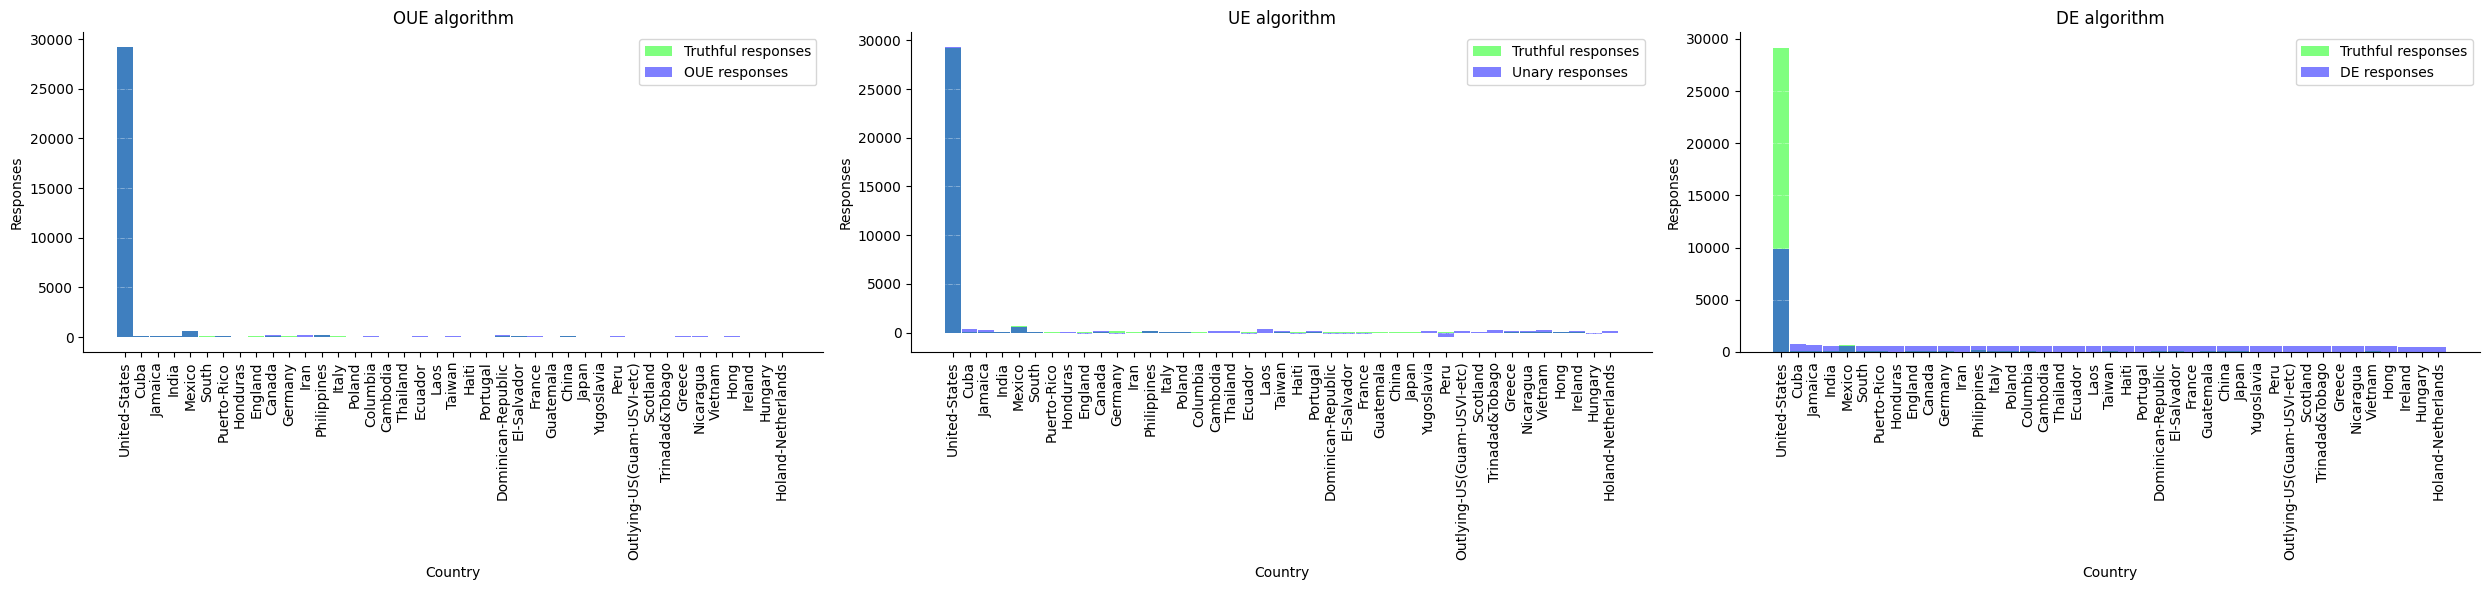

In [175]:
histogram_maker_3subplots(3, 'Country')

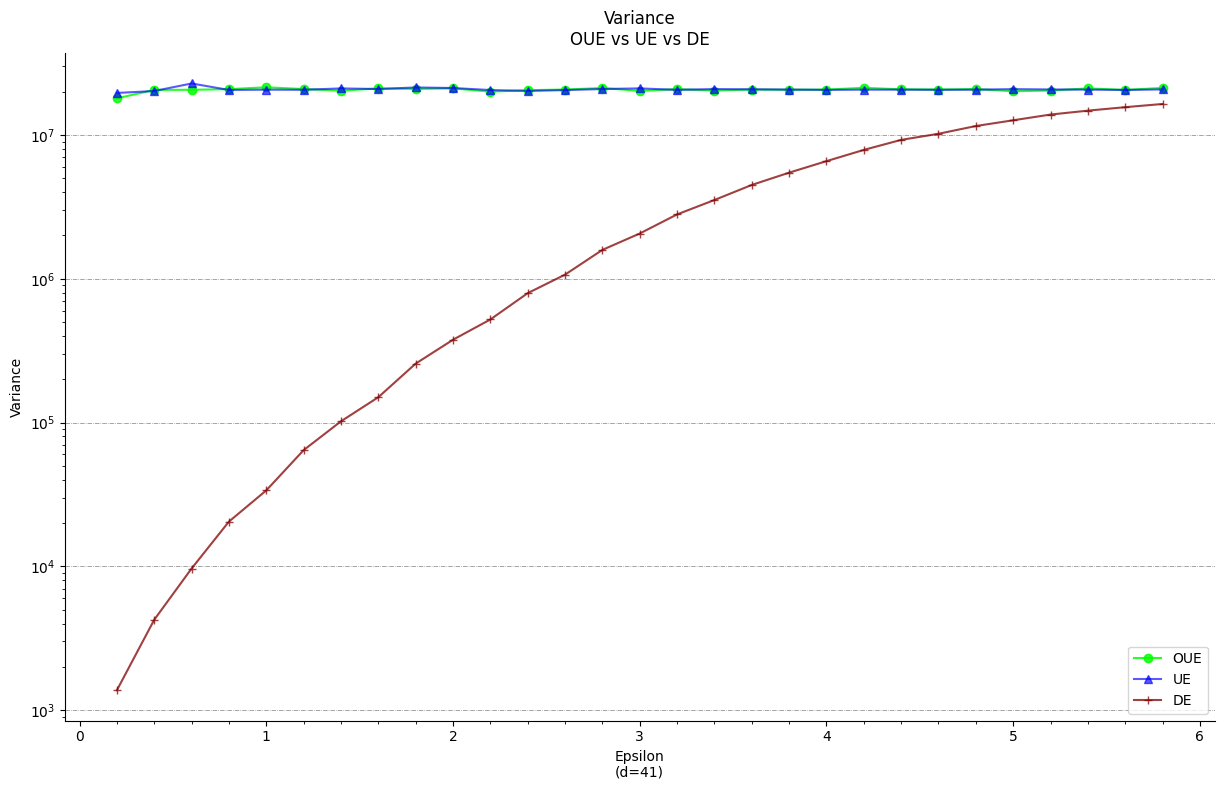

In [170]:
plot_var_3transplots(30, 'Country')

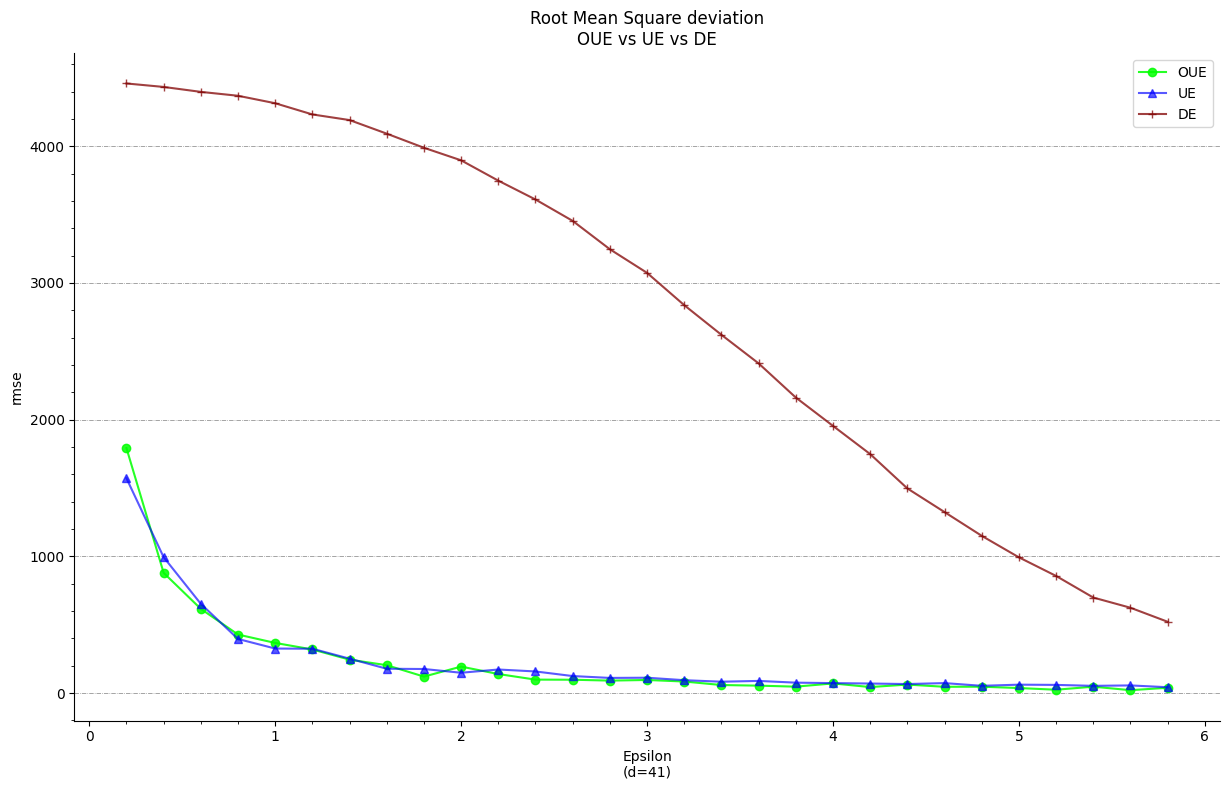

In [171]:
plot_rmse_3transplots(30, 'Country')

## Age

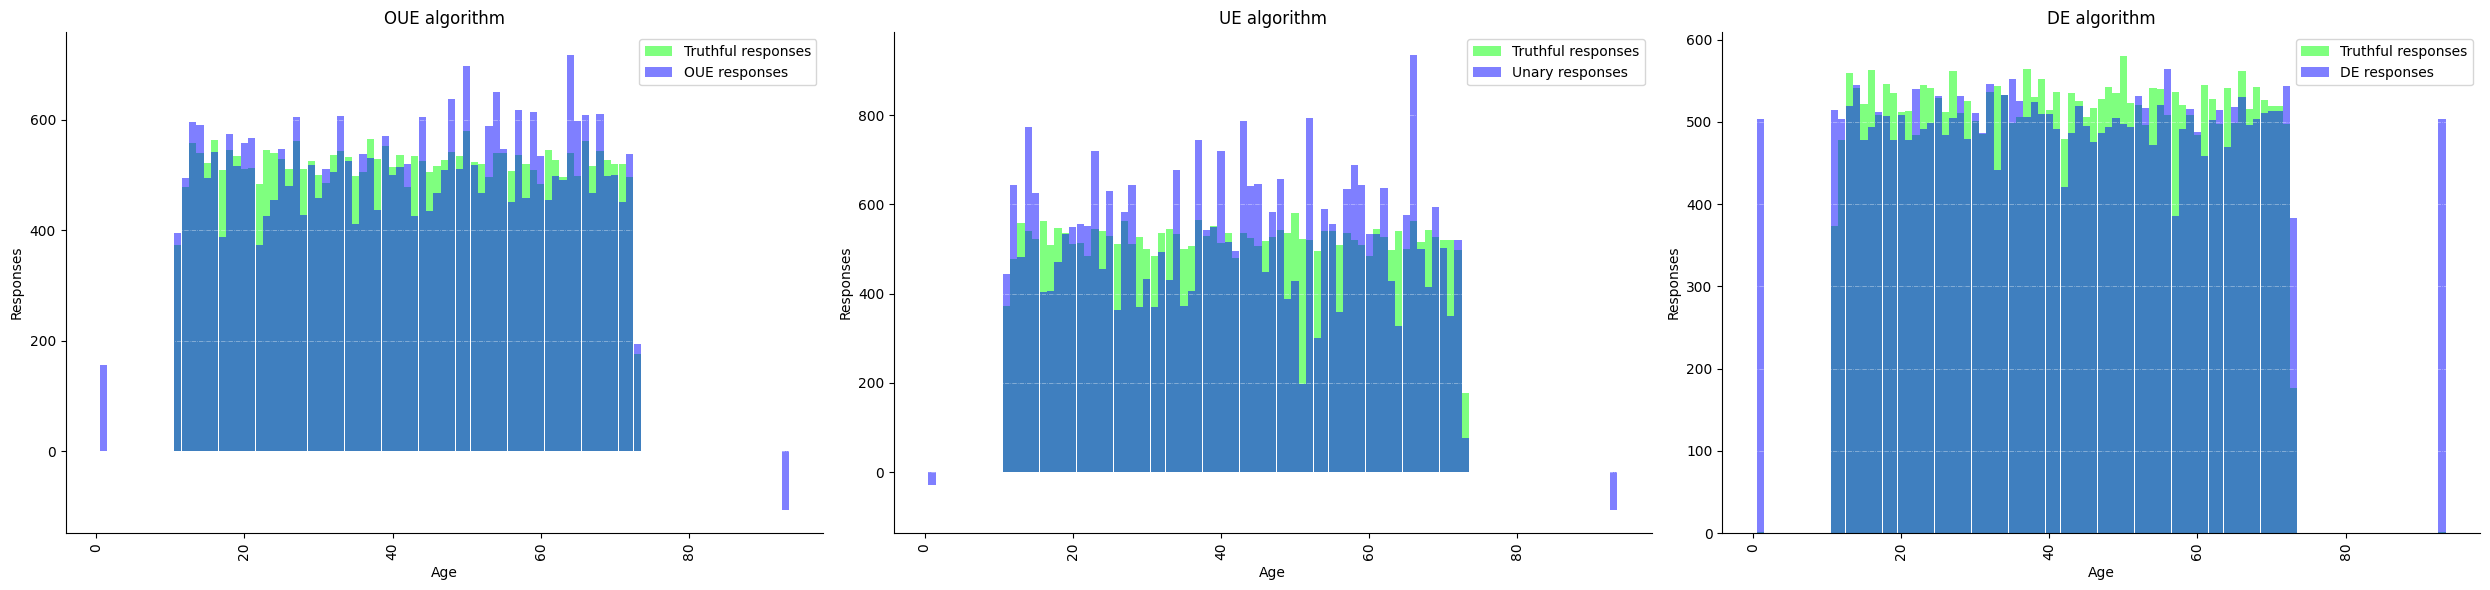

In [31]:
histogram_maker_3subplots(3, 'Age')

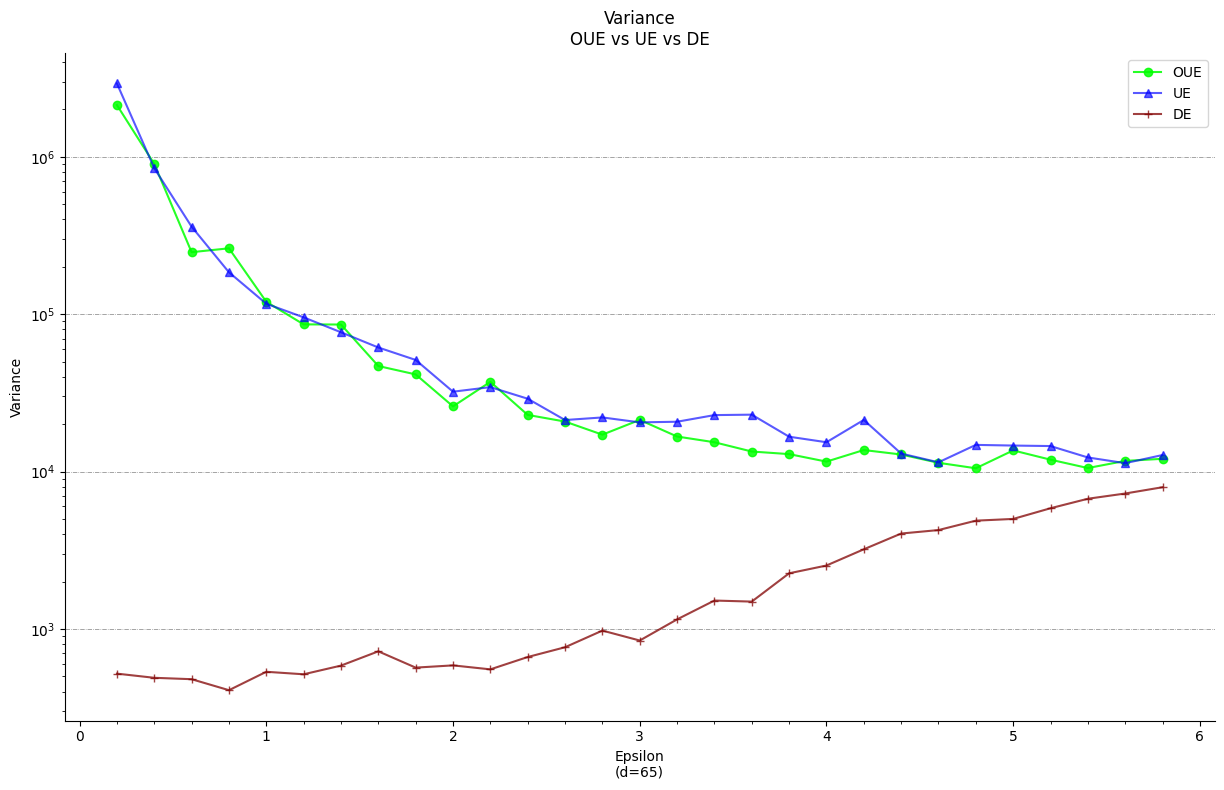

In [32]:
plot_var_3transplots(30, 'Age')

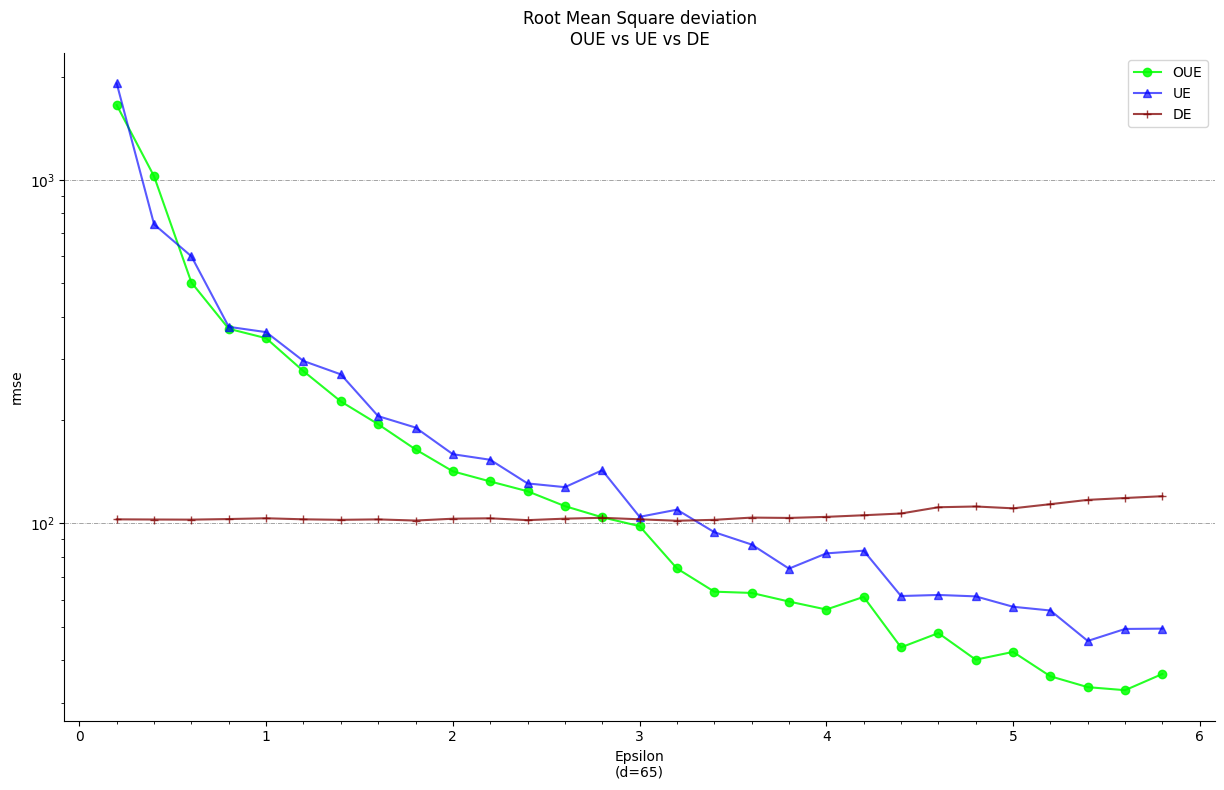

In [35]:
plot_rmse_3transplots(30, 'Age')